In [19]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

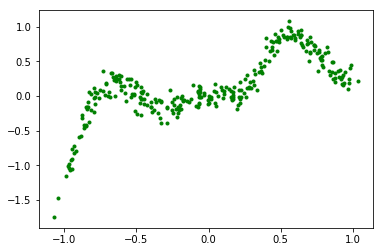

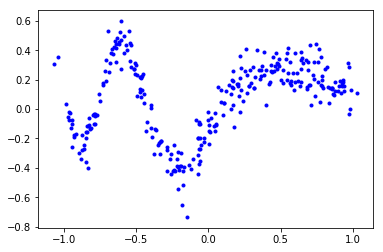

In [20]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y0= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y0 = y0 + noise

y1 = 0.4*(-x+np.cos(15*(x-0.85)**2))+0.15
noise = np.random.normal(0,0.1, x.shape)
y1 = y1 + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy0 = y0.reshape(-1,1)
yy1 = y1.reshape(-1,1)

yy = np.c_[y0,y1]
%matplotlib inline
plt.scatter(x, y0, marker='.', color='g')
plt.show()
plt.scatter(x, y1, marker='.', color='b')
plt.show()

In [21]:
yy.shape

(300, 2)

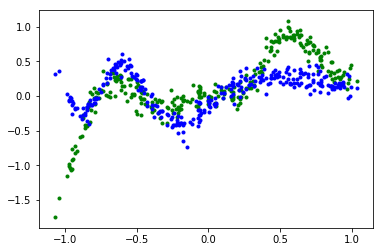

In [22]:
## plotting together
%matplotlib inline
plt.scatter(x, y0, marker='.', color='g')
plt.scatter(x, y1, marker='.', color='b')
plt.show()

## Building model for both at once

In [23]:
n_hidden = 4
optimizer = tnn.Adam()

net = tnn.AutoForm(new_layers=True)
layer1 = tnn.NonLinearLayer(1, n_hidden, activation=tnn.LeakyRelu(), optimizer=optimizer)
layer2 = tnn.LinearLayer(n_hidden, 2, optimizer=optimizer)

_______________________
epoch 0
Loss 0.2453123498089741

_______________________
epoch 100
Loss 0.030722751483049607

_______________________
epoch 200
Loss 0.019381294721691245

_______________________
epoch 300
Loss 0.01512833417926941

_______________________
epoch 400
Loss 0.013645194925261764

_______________________
epoch 500
Loss 0.012863384461477301

_______________________
epoch 600
Loss 0.012485003273020793

_______________________
epoch 700
Loss 0.012288547209410498

_______________________
epoch 800
Loss 0.012171175278970712

_______________________
epoch 900
Loss 0.012086397690646077

_______________________
epoch 1000
Loss 0.012020845165455549

_______________________
epoch 1100
Loss 0.011971245230390126

_______________________
epoch 1200
Loss 0.011932541698384003

_______________________
epoch 1300
Loss 0.011904309092646939

_______________________
epoch 1400
Loss 0.011883662792160861

_______________________
epoch 1500
Loss 0.011868665538235568

_______________________

TclError: invalid command name "pyimage80"

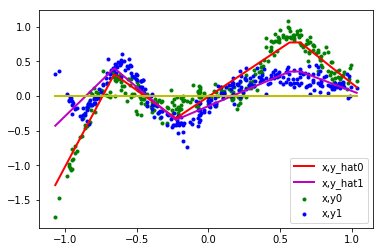

In [24]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.ion()
fig.show()
fig.canvas.draw()

for step in range(100000):
    
    y_out = net.forward(xx)
    loss = tnn.MseLoss.loss(y_out, yy)
    
    dy = tnn.MseLoss.del_loss(y_out, yy)
    dx = net.backward(dy)
    
    net.update()
    
    if step % 100 == 0:

        print('_______________________')
        print("epoch", step)
        print("Loss", loss)

        ax.clear()
        plt.scatter(x, y0, marker='.', color='g', label='x,y0')
        plt.scatter(x, y1, marker='.', color='b', label='x,y1')
        
        plt.plot(x, y_out[:,0], c='r', lw=2, label='x,y_hat0')
        plt.plot(x, y_out[:,1], c='m', lw=2, label='x,y_hat1')
        
#         plt.scatter(x, dx.reshape(-1), marker='*', c='c', lw=1, label='x,dx')
        plt.plot(x, np.zeros_like(x), c='y', lw=2)
        plt.legend()
        
        fig.canvas.draw()
        
        plt.pause(0.01)
        print()
        if loss < 0.0025:
            print('fitted to our expectation')
            plt.pause(50)
            break

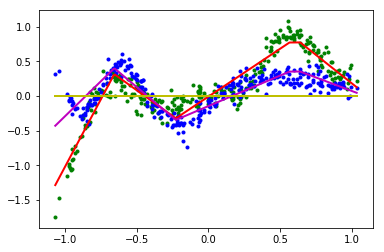

In [25]:
%matplotlib inline
plt.scatter(x, y0, marker='.', color='g', label='x,y0')
plt.scatter(x, y1, marker='.', color='b', label='x,y1')

plt.plot(x, y_out[:,0], c='r', lw=2, label='x,y_hat0')
plt.plot(x, y_out[:,1], c='m', lw=2, label='x,y_hat1')

#         plt.scatter(x, dx.reshape(-1), marker='*', c='c', lw=1, label='x,dx')
plt.plot(x, np.zeros_like(x), c='y', lw=2)

In [26]:
print('the combined error is', loss)
loss_a = tnn.MseLoss.loss(y_out[:, :1], yy[:, :1])
loss_b = tnn.MseLoss.loss(y_out[:, 1:], yy[:, 1:])
print('the error "a" is', loss_a)
print('the error "b" is', loss_b)

the combined error is 0.01182439712065508
the error "a" is 0.012862618035433844
the error "b" is 0.010786176205876312


In [57]:
layer1.output.std(axis=0)

array([0.09958287, 0.83247914, 0.14511894, 0.50121861])

### Splitting highest std neuron -> Optimizing

In [30]:
import copy

In [115]:
layer1.output.std(axis=0)

array([0.12963291, 1.32087192, 1.3699303 , 1.31373267, 1.3683462 ,
       1.22269643, 0.1469631 , 0.48966796])

In [112]:
split_index = layer1.output.std(axis=0).argmax()
w0_ = np.copy(layer1.weights)
b0_ = np.copy(layer1.bias)
w1_ = np.copy(layer2.weights)
b1_ = np.copy(layer2.bias)

w0_ = np.insert(w0_, split_index, w0_[:,split_index], axis=1)
b0_ = np.insert(b0_, split_index, b0_[split_index])
w1_ = np.insert(w1_, split_index, w1_[split_index], axis=0)
w1_[split_index,0] = 0.
w1_[split_index+1,1] = 0.

In [113]:
optimizer = tnn.Adam()

net_ = tnn.AutoForm(new_layers=True)
layer1_ = tnn.NonLinearLayer(1, n_hidden, activation=tnn.LeakyRelu(),
                            weights=copy.deepcopy(w0_),
                            bias=copy.deepcopy(b0_),
                            optimizer=optimizer)
layer2_ = tnn.LinearLayer(n_hidden, 2,
                         weights=copy.deepcopy(w1_),
                         optimizer=optimizer)

In [114]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.show()

for step in range(100000):
    
    y_out = net_.forward(xx)
    loss = tnn.MseLoss.loss(y_out, yy)
    
    dy = tnn.MseLoss.del_loss(y_out, yy)
    dx = net_.backward(dy)
    
    net_.update()
    
    if step % 100 == 0:

        print('_______________________')
        print("epoch", step)
        print("Loss", loss)

        ax.clear()
        plt.scatter(x, y0, marker='.', color='g', label='x,y0')
        plt.scatter(x, y1, marker='.', color='b', label='x,y1')
        
        plt.plot(x, y_out[:,0], c='r', lw=2, label='x,y_hat0')
        plt.plot(x, y_out[:,1], c='m', lw=2, label='x,y_hat1')
        
#         plt.scatter(x, dx.reshape(-1), marker='*', c='c', lw=1, label='x,dx')
        plt.plot(x, np.zeros_like(x), c='y', lw=2)
        plt.legend()
        
        fig.canvas.draw()
        
        plt.pause(0.01)
        print()
        if loss < 0.0025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
epoch 0
Loss 0.20958697519233976

_______________________
epoch 100
Loss 0.01398145807930104

_______________________
epoch 200
Loss 0.009592795752539712

_______________________
epoch 300
Loss 0.009074501950321017

_______________________
epoch 400
Loss 0.009004350862231971

_______________________
epoch 500
Loss 0.008987440697585917

_______________________
epoch 600
Loss 0.008985475615329768

_______________________
epoch 700
Loss 0.008985013682984764

_______________________
epoch 800
Loss 0.008984794368425818

_______________________
epoch 900
Loss 0.008984614725846857

_______________________
epoch 1000
Loss 0.008984422065625847

_______________________
epoch 1100
Loss 0.008984233179180356

_______________________
epoch 1200
Loss 0.008984021230674787

_______________________
epoch 1300
Loss 0.00898381038872801


TclError: invalid command name "pyimage265"

### if satisfied, make this the default layers

In [109]:
layer1 = layer1_
layer2 = layer2_

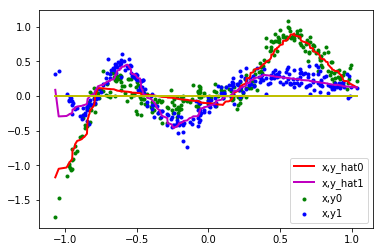

In [110]:
%matplotlib inline
plt.scatter(x, y0, marker='.', color='g', label='x,y0')
plt.scatter(x, y1, marker='.', color='b', label='x,y1')

plt.plot(x, y_out0, c='r', lw=2, label='x,y_hat0')
plt.plot(x, y_out1, c='m', lw=2, label='x,y_hat1')

plt.plot(x, np.zeros_like(x), c='y', lw=2)
plt.legend()

In [ ]:
print('the error "a" is', loss0)
print('the error "b" is', loss1)